In [15]:
import uproot
import pandas as pd
import numpy as np
import os
import glob
import awkward as ak
import vector


def process_file(file_path, is_mc=False):
  
    branches_to_read = [
        "lep_pt", "lep_eta", "lep_phi", "lep_E",
        "lep_charge", "lep_type"
    ]
    if is_mc:
        branches_to_read.extend(["mcWeight", "scaleFactor_PILEUP", "scaleFactor_ELE", "scaleFactor_MUON"])

    try:
        with uproot.open(file_path) as file:
            tree = file["mini"]
            events = tree.arrays(branches_to_read, library="ak")
    except Exception as e:
        print(f"Warning: Could not process {os.path.basename(file_path)}. Reason: {e}")
        return None

    four_lepton_mask = ak.num(events.lep_pt) == 4
    events = events[four_lepton_mask]
    charge_mask = ak.sum(events.lep_charge, axis=1) == 0
    events = events[charge_mask]

    if len(events) == 0: return None

    leptons = vector.zip({"pt": events.lep_pt, "eta": events.lep_eta, "phi": events.lep_phi, "E": events.lep_E})
    four_lepton_system = leptons[:, 0] + leptons[:, 1] + leptons[:, 2] + leptons[:, 3]

    df = pd.DataFrame()
    for i in range(4):
        df[f'lep_pt_{i}'] = leptons.pt[:, i] /1000
        df[f'lep_eta_{i}'] = leptons.eta[:, i]
        df[f'lep_phi_{i}'] = leptons.phi[:, i]
        df[f'lep_E_{i}'] = leptons.E[:, i] / 1000
        df[f'lep_charge_{i}'] = events.lep_charge[:, i]
        df[f'lep_type_{i}'] = events.lep_type[:, i]

    df['M_4l'] = four_lepton_system.mass / 1000
    df['pT_4l'] = four_lepton_system.pt / 1000

    if is_mc:
        df['mcWeight'] = events.mcWeight
        df['scaleFactor_PILEUP'] = events.scaleFactor_PILEUP
        df['scaleFactor_ELE'] = events.scaleFactor_ELE
        df['scaleFactor_MUON'] = events.scaleFactor_MUON

    return df

base_dir = "dataset/4lep 2"
mc_dir = os.path.join(base_dir, "MC")


signal_ids = ['ggH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
background_ids = ['Zee', 'Zmumu']

signal_files = [f for f in glob.glob(os.path.join(mc_dir, "*.root")) if any(id_str in f for id_str in signal_ids)]
signal_dfs = [process_file(f, is_mc=True) for f in signal_files]
signal_df = pd.concat([df for df in signal_dfs if df is not None], ignore_index=True)
signal_df['is_signal'] = 1


background_files = [f for f in glob.glob(os.path.join(mc_dir, "*.root")) if any(id_str in f for id_str in background_ids)]
background_dfs = [process_file(f, is_mc=True) for f in background_files]
background_df = pd.concat([df for df in background_dfs if df is not None], ignore_index=True)
background_df['is_signal'] = 0


mc_df = pd.concat([signal_df, background_df], ignore_index=True)


mc_df['total_weight'] = (
    mc_df['mcWeight'] *
    mc_df['scaleFactor_PILEUP'] *
    mc_df['scaleFactor_ELE'] *
    mc_df['scaleFactor_MUON']
).fillna(0) 


print("\n--- FINAL VERIFICATION ---")
print(f"Total events in final mc_df: {len(mc_df)}")
print("Value counts for 'is_signal' column:")
print(mc_df['is_signal'].value_counts())


--- FINAL VERIFICATION ---
Total events in final mc_df: 187696
Value counts for 'is_signal' column:
is_signal
1    182914
0      4782
Name: count, dtype: int64


In [16]:
"""done DEBUG -> Contra all signals are being detected 





base_dir = "dataset/4lep 2"
mc_dir = os.path.join(base_dir, "MC")


signal_ids = ['ggH125_ZZ4lep', 'WH125_ZZ4lep', 'ZH125_ZZ4lep']
background_ids = ['Zee', 'Zmumu']


all_mc_files = [os.path.basename(f) for f in glob.glob(os.path.join(mc_dir, "*.root"))]

print("--- Checking for Signal Files ---")
for id_str in signal_ids:
 
    if any(id_str in f for f in all_mc_files):
        print(f" Found: {id_str}")
    else:
        print(f" Missing: {id_str}")

print("\n--- Checking for Background Files ---")
for id_str in background_ids:
    if any(id_str in f for f in all_mc_files):
        print(f" Found: {id_str}")
    else:
        print(f" Missing: {id_str}")

        """
        

'done DEBUG -> Contra all signals are being detected \n\n\n\n\n\nbase_dir = "dataset/4lep 2"\nmc_dir = os.path.join(base_dir, "MC")\n\n\nsignal_ids = [\'ggH125_ZZ4lep\', \'WH125_ZZ4lep\', \'ZH125_ZZ4lep\']\nbackground_ids = [\'Zee\', \'Zmumu\']\n\n\nall_mc_files = [os.path.basename(f) for f in glob.glob(os.path.join(mc_dir, "*.root"))]\n\nprint("--- Checking for Signal Files ---")\nfor id_str in signal_ids:\n \n    if any(id_str in f for f in all_mc_files):\n        print(f" Found: {id_str}")\n    else:\n        print(f" Missing: {id_str}")\n\nprint("\n--- Checking for Background Files ---")\nfor id_str in background_ids:\n    if any(id_str in f for f in all_mc_files):\n        print(f" Found: {id_str}")\n    else:\n        print(f" Missing: {id_str}")\n\n        '


--- Generating Plots ---


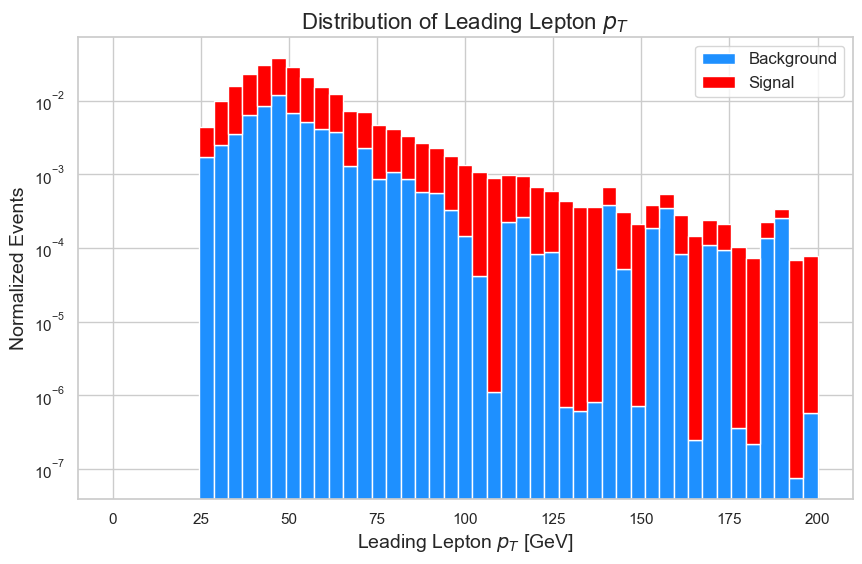

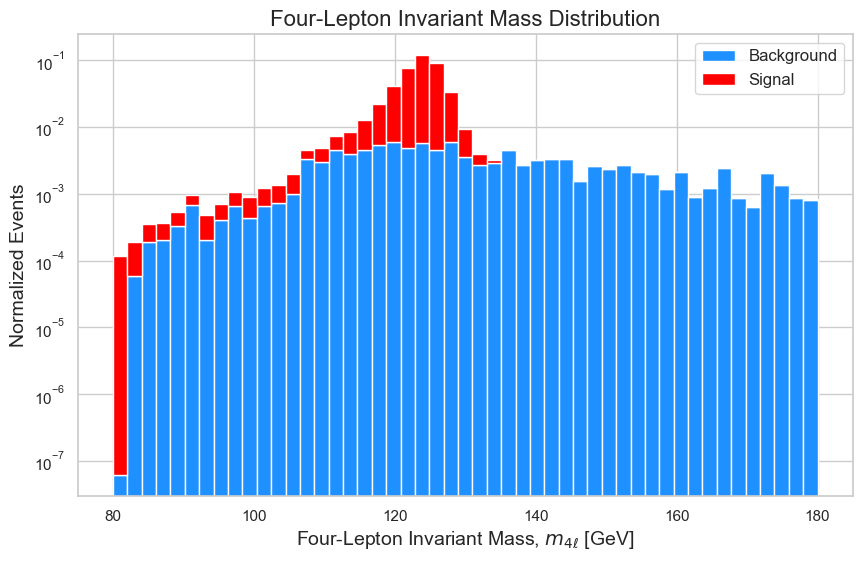

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme(style="whitegrid")
def plot_stacked_histogram(variable, bins, x_label, title):
    plt.figure(figsize=(10, 6))
    signal_data = mc_df[mc_df['is_signal'] == 1][variable]
    background_data = mc_df[mc_df['is_signal'] == 0][variable]
    signal_weights = mc_df[mc_df['is_signal'] == 1]['total_weight']
    background_weights = mc_df[mc_df['is_signal'] == 0]['total_weight']
    plt.hist([background_data, signal_data],
             bins=bins, weights=[background_weights, signal_weights],
             label=['Background', 'Signal'], color=['dodgerblue', 'red'],
             stacked=True, density=True)
    plt.xlabel(x_label, fontsize=14)
    plt.ylabel("Normalized Events", fontsize=14)
    plt.title(title, fontsize=16)
    plt.legend(fontsize=12)
    plt.yscale('log')
    plt.show()

print("\n--- Generating Plots ---")
plot_stacked_histogram(
    variable='lep_pt_0', bins=np.linspace(0, 200, 50),
    x_label="Leading Lepton $p_T$ [GeV]",
    title="Distribution of Leading Lepton $p_T$")
plot_stacked_histogram(
    variable='M_4l', bins=np.linspace(80, 180, 50),
    x_label="Four-Lepton Invariant Mass, $m_{4\\ell}$ [GeV]",
    title="Four-Lepton Invariant Mass Distribution")


In [18]:
""" !!!DEBUG!!!
print(f"Total events in mc_df: {len(mc_df)}")
print("Value counts for 'is_signal' column:")
print(mc_df['is_signal'].value_counts())
print("\nDescription of 'lep_pt_0' column:")
print(mc_df['lep_pt_0'].describe())

base_dir = "dataset/4lep 2"
mc_dir = os.path.join(base_dir, "MC")


mc_files_to_process = [f for f in glob.glob(os.path.join(mc_dir, "*.root")) if 'ggH125_ZZ4l' in f or 'ZZ_4l' in f]

print("Files being processed:")
for f in mc_files_to_process:
   
    print(f"  - {os.path.basename(f)}")


print(mc_df['is_signal'].value_counts())


print("--- Final Column Check ---")

# Check M_4l (the working column)
print("\nDescription of 'M_4l':")
print(mc_df['M_4l'].describe())
print(f"Number of NaN values in 'M_4l': {mc_df['M_4l'].isna().sum()}")

# Check lep_pt_0 (the failing column)
print("\nDescription of 'lep_pt_0':")
print(mc_df['lep_pt_0'].describe())
print(f"Number of NaN values in 'lep_pt_0': {mc_df['lep_pt_0'].isna().sum()}")

"""

' !!!DEBUG!!!\nprint(f"Total events in mc_df: {len(mc_df)}")\nprint("Value counts for \'is_signal\' column:")\nprint(mc_df[\'is_signal\'].value_counts())\nprint("\nDescription of \'lep_pt_0\' column:")\nprint(mc_df[\'lep_pt_0\'].describe())\n\nbase_dir = "dataset/4lep 2"\nmc_dir = os.path.join(base_dir, "MC")\n\n\nmc_files_to_process = [f for f in glob.glob(os.path.join(mc_dir, "*.root")) if \'ggH125_ZZ4l\' in f or \'ZZ_4l\' in f]\n\nprint("Files being processed:")\nfor f in mc_files_to_process:\n   \n    print(f"  - {os.path.basename(f)}")\n\n\nprint(mc_df[\'is_signal\'].value_counts())\n\n\nprint("--- Final Column Check ---")\n\n# Check M_4l (the working column)\nprint("\nDescription of \'M_4l\':")\nprint(mc_df[\'M_4l\'].describe())\nprint(f"Number of NaN values in \'M_4l\': {mc_df[\'M_4l\'].isna().sum()}")\n\n# Check lep_pt_0 (the failing column)\nprint("\nDescription of \'lep_pt_0\':")\nprint(mc_df[\'lep_pt_0\'].describe())\nprint(f"Number of NaN values in \'lep_pt_0\': {mc_df[\'le

In [19]:
"""DEBUG


# Filter for signal and background first
signal_df = mc_df[mc_df['is_signal'] == 1]
background_df = mc_df[mc_df['is_signal'] == 0]

print("\n--- Leading Lepton Types ---")
print("Signal:")
print(signal_df['lep_type_0'].value_counts())
print("\nBackground:")
print(background_df['lep_type_0'].value_counts())

"""

'DEBUG\n\n\n# Filter for signal and background first\nsignal_df = mc_df[mc_df[\'is_signal\'] == 1]\nbackground_df = mc_df[mc_df[\'is_signal\'] == 0]\n\nprint("\n--- Leading Lepton Types ---")\nprint("Signal:")\nprint(signal_df[\'lep_type_0\'].value_counts())\nprint("\nBackground:")\nprint(background_df[\'lep_type_0\'].value_counts())\n\n'

Number of negative weights before correction: 1100
Initiated i think 
[0]	train-auc:0.84654	test-auc:0.84459


/var/folders/j7/b6jr6vmn7hl62gmpmq1gh2yc0000gn/T/ipykernel_10167/3878448100.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weights[weights < 0] = 0


[10]	train-auc:0.98052	test-auc:0.97071
[20]	train-auc:0.98584	test-auc:0.97306
[30]	train-auc:0.98874	test-auc:0.97481
[40]	train-auc:0.99058	test-auc:0.97488
[50]	train-auc:0.99267	test-auc:0.97408
[51]	train-auc:0.99296	test-auc:0.97410

 Filled Auc : 0.9593


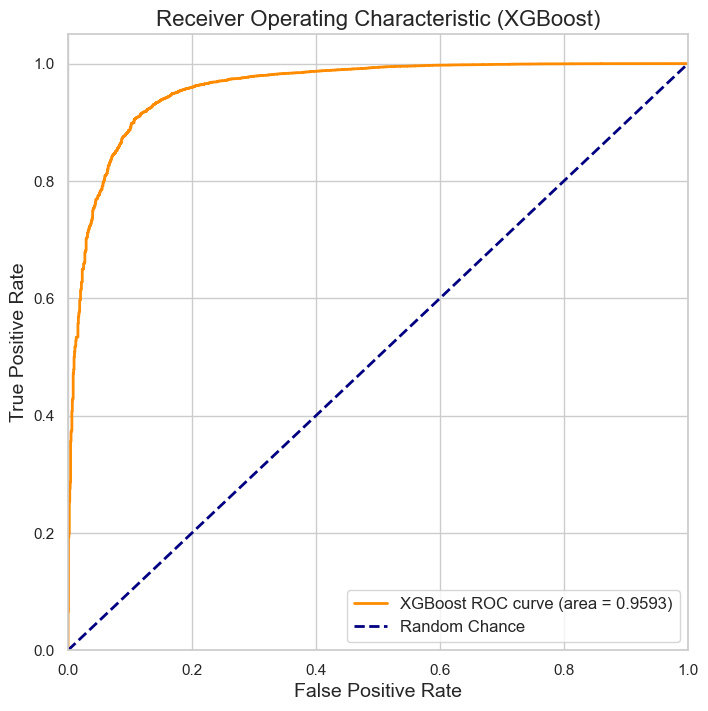

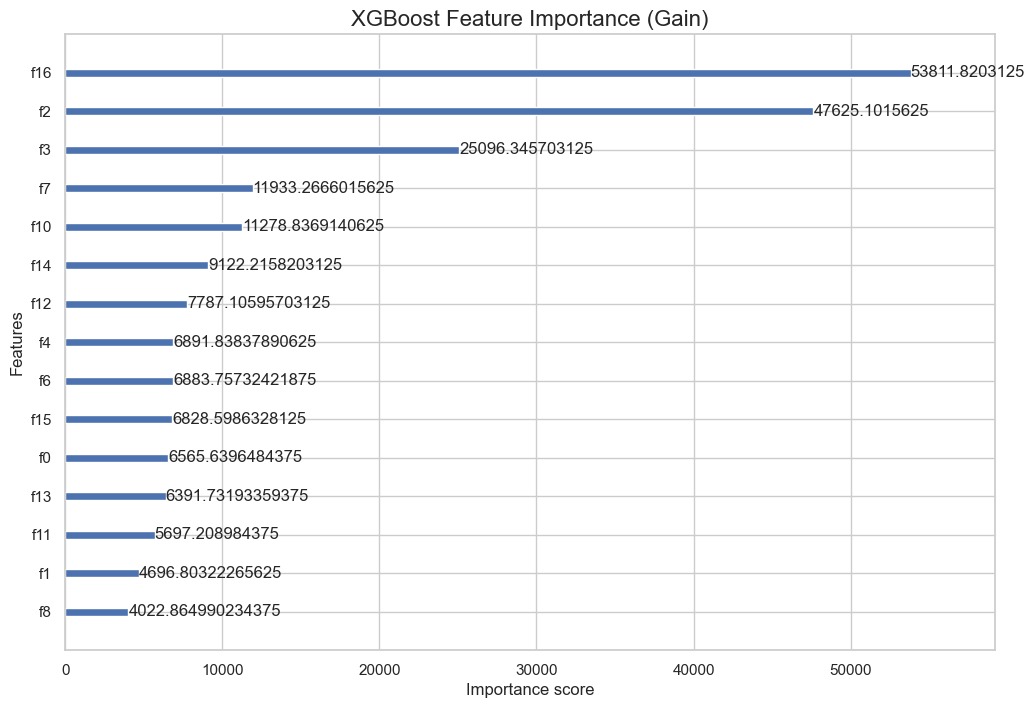

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

features = [
    'lep_pt_0', 'lep_pt_1', 'lep_pt_2', 'lep_pt_3',
    'lep_eta_0', 'lep_eta_1', 'lep_eta_2', 'lep_eta_3',
    'lep_phi_0', 'lep_phi_1', 'lep_phi_2', 'lep_phi_3',
    'lep_E_0', 'lep_E_1', 'lep_E_2', 'lep_E_3',
    'M_4l'
]

X = mc_df[features]
y = mc_df['is_signal']
weights = mc_df['total_weight']

# DEBUG LINE ? -> Confirm debug verified before removing 
# Try and lets set the Nan or -ve values to 0 and try again ? 
#NOOOOOOOO DONT REEEEDEEEMMMMM }


print(f"Number of negative weights before correction: {(weights < 0).sum()}")
weights[weights < 0] = 0


X = X.astype('float32')
y = y.astype('int32')
weights = weights.astype('float32')

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.3, random_state=42, stratify=y
)

dtrain = xgb.DMatrix(X_train.values, label=y_train.values, weight=w_train.values)
dtest = xgb.DMatrix(X_test.values, label=y_test.values, weight=w_test.values)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.1,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

num_boost_round = 250
evals = [(dtrain, 'train'), (dtest, 'test')]

print("Initiated i think ")
bst = xgb.train(
    params,
    dtrain,
    num_boost_round,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=10
)

y_pred_proba_xgb = bst.predict(dtest)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

print(f"\n Filled Auc : {auc_xgb:.4f}")

plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'XGBoost ROC curve (area = {auc_xgb:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (XGBoost)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 8))
xgb.plot_importance(bst, ax=ax, importance_type='gain', max_num_features=15)
plt.title('XGBoost Feature Importance (Gain)', fontsize=16)
plt.show()

# Warning , overfitting starts at 41-50 , do not overstate epoch or remove the defender factor


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,417 (111.00 KB)

 Trainable params: 27,777 (108.50 KB)

 Non-trainable params: 640 (2.50 KB)


🚀 Training Deep Neural Network model...
Epoch 1/100


2025-08-01 13:49:32.546648: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


103/103 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - auc: 0.6577 - loss: 21.7438 - val_auc: 0.9174 - val_loss: 13.4345
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.8568 - loss: 12.0885 - val_auc: 0.9325 - val_loss: 9.8270
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.8900 - loss: 10.6105 - val_auc: 0.9376 - val_loss: 8.0942
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - auc: 0.8974 - loss: 10.4001 - val_auc: 0.9373 - val_loss: 7.3734
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - auc: 0.9094 - loss: 8.8333 - val_auc: 0.9387 - val_loss: 7.2358
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - auc: 0.9155 - loss: 8.3188 - val_auc: 0.9411 - val_loss: 6.7784
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - auc: 0.9119 - loss: 8.2814 - val_auc: 0.9445 - val_loss: 6.3339
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - auc: 0.9214 - loss: 8.4217 - val_auc: 0.9461 - val_loss: 6.1750
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 27m

2025-08-01 13:51:42.446528: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1760/1760 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


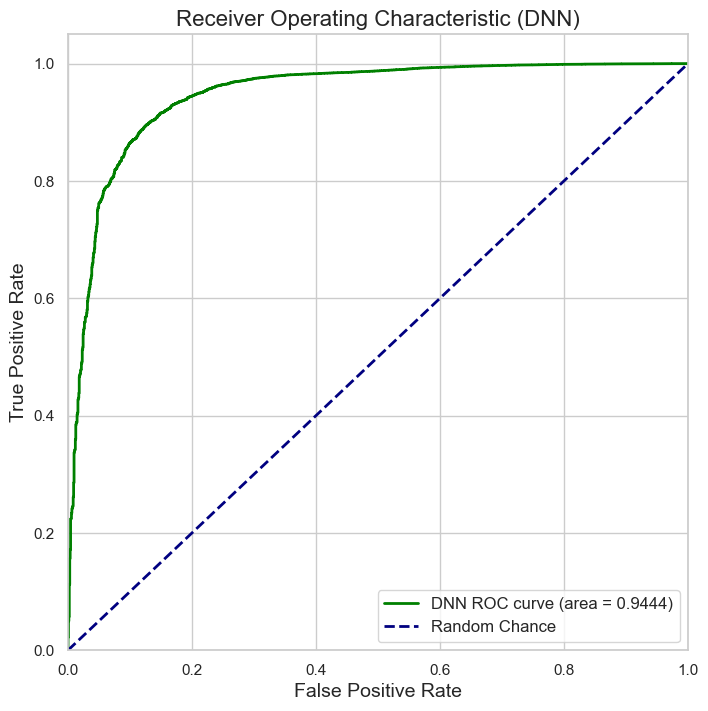

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def build_dnn_model(input_shape):
    model = keras.Sequential([

        layers.Input(shape=input_shape),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(128),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])
    return model

model_dnn = build_dnn_model(X_train_scaled.shape[1:])
model_dnn.summary()


model_dnn.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[keras.metrics.AUC(name='auc')]
)


callbacks = [

    keras.callbacks.EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
]

print("\model initiated")
history = model_dnn.fit(
    X_train_scaled,
    y_train,
    sample_weight=w_train,
    validation_split=0.2,
    epochs=100,
    batch_size=1024,
    callbacks=callbacks,
    verbose=1
)


print("\nEVAL_>>>>>>>>>>>.")

results_dnn = model_dnn.evaluate(X_test_scaled, y_test, sample_weight=w_test, verbose=0)
auc_dnn = results_dnn[1] 
print(f"DNN Test AUC: {auc_dnn:.4f}")

y_pred_proba_dnn = model_dnn.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, _ = roc_curve(y_test, y_pred_proba_dnn)

plt.figure(figsize=(8, 8))
plt.plot(fpr_dnn, tpr_dnn, color='green', lw=2, label=f'DNN ROC curve (area = {auc_dnn:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (DNN)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

